In [1]:
import configuration as config
import utilities as utils
import DataLoader as dl
import ModelGenerator as mg
import Train
import ModelValidation as mv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
credit_card_data = utils.get_data(config.INPUT_FILE_PATH)

Data loaded from input CSV
Shape of input file:(284807, 31)


In [4]:
no_fraud, fraud = credit_card_data.Class.value_counts()
print(f'No Fraud {no_fraud}')
print(f'Fraud {fraud}')
print(f'Fraud proportion {round(utils.percentage(fraud, no_fraud + fraud), 2)}%')

No Fraud 284315
Fraud 492
Fraud proportion 0.17%


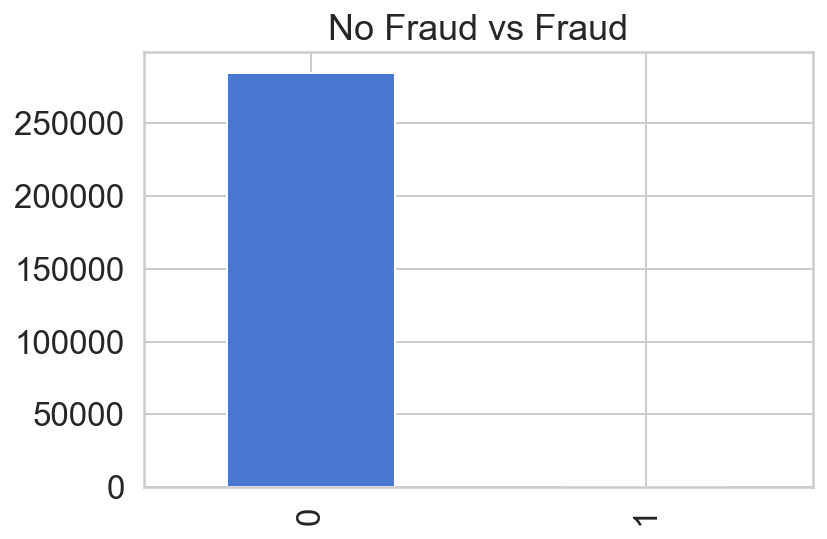

In [5]:
utils.plot_class_balance(credit_card_data, 'Class', title="No Fraud vs Fraud");

In [6]:
data = dl.DataGenerator(credit_card_data, split=0.05)

In [7]:
model = mg.build_model(data.X_train)

In [8]:
history = Train.Trainer(model, data).history

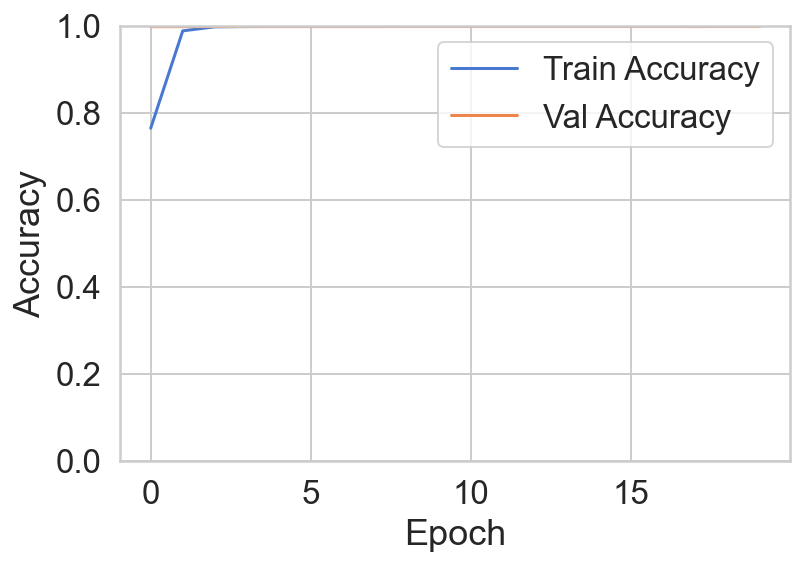

In [9]:
mv.plot_accuracy(history)

In [10]:
model.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE)

14241/14241 [==============================] - 0s 2us/sample - loss: 0.0111 - accuracy: 0.9985


[0.011085252833233717, 0.9985254]

In [11]:
def awesome_model_predict(features):
  return np.full((features.shape[0], ), 0)

In [13]:
y_pred = awesome_model_predict(data.X_test)

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, data.y_test)

0.9985253844533389

### Model Validation



In [16]:
model_pred = model.predict(data.X_test, batch_size=config.BATCH_SIZE)

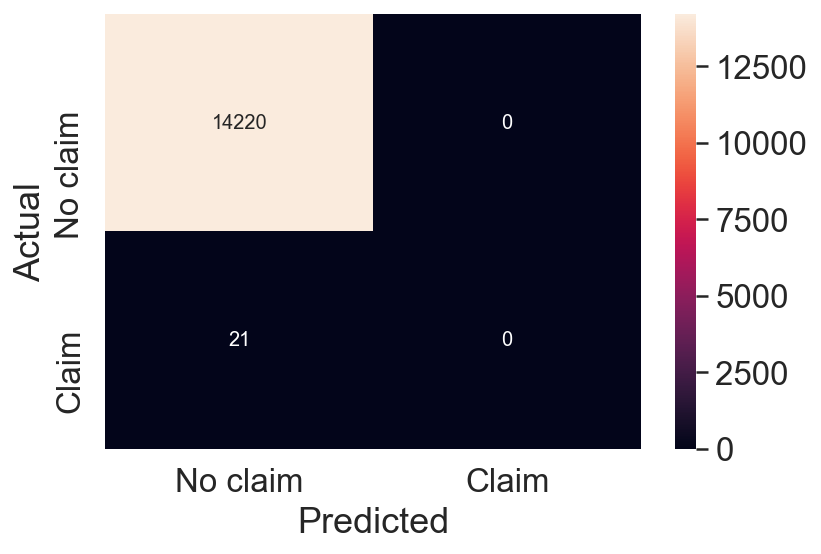

In [18]:
mv.plot_cm(data.y_test, model_pred)

In [19]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]